# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [6]:
if os.name=='nt':
    !pip install wget
    import wget


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tensorflow

In [ ]:
!pip install protobuf matplotlib

In [ ]:
!pip install gin-config

In [ ]:
!pip install tensorflow-addons

In [7]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [9]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [12]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [10]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


In [ ]:
!pip install pytz

# 4. Copy Model Config to Training Folder

In [11]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Update Config For Transfer Learning

In [12]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [13]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [17]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 4e-005
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0
           stddev: 0.01
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     override_base_feature_extractor_hyperparams: true
     use_depthwise: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10
       x_scale: 10
       height_scale: 5
       width_scale: 5
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
       unmatch

In [14]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [15]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [16]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [21]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [22]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

In [ ]:
!{command}

# 7. Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 8. Load Train Model From Checkpoint

In [17]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

D:\ML Projects\Practice collection\P4\p4\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [18]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [ ]:
!pip install opencv-python

In [2]:
!pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.7.0.72-cp37-abi3-win_amd64.whl (44.9 MB)


In [19]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [21]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars411.png')

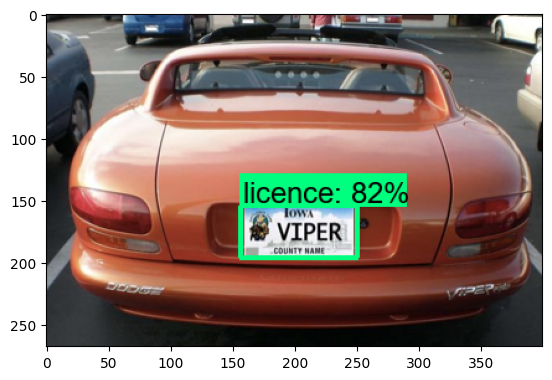

In [22]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Apply OCR to Detection

In [ ]:
!pip install easyocr

In [23]:
import easyocr

In [24]:
detection_threshold=0.7

In [25]:
image=image_np_with_detections
scores=list(filter(lambda x: x>detection_threshold, detections['detection_scores']))
boxes=detections['detection_boxes'][:len(scores)]
classes=detections['detection_classes'][:len(scores)]

In [26]:
width=image.shape[1]
height=image.shape[0]

[([[26, 8], [86, 8], [86, 32], [26, 32]], 'VIPER', 0.9998703975002075)]


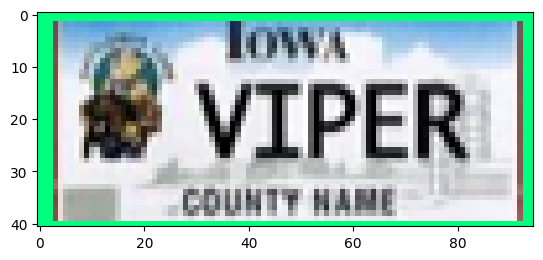

In [27]:
#Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    roi=box*[height, width, height, width]
    region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader=easyocr.Reader(['en'])
    ocr_result=reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

# OCR Filtering

In [28]:
region_threshold=0.6

In [29]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size=region.shape[0]*region.shape[1]
    
    plate=[]
    for result in ocr_result:
        length=np.sum(np.subtract(result[0][1], result[0][0]))
        width=np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*width / rectangle_size>region_threshold:
            plate.append(result[1])
    return plate

In [30]:
filter_text(region, ocr_result, region_threshold)

[]

# Bring it Together

In [31]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threshold
    scores=list(filter(lambda x: x>detection_threshold, detections['detection_scores']))
    boxes=detections['detection_boxes'][:len(scores)]
    classes=detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width=image.shape[1]
    height=image.shape[0]
    
    #Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi=box*[height, width, height, width]
        region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader=easyocr.Reader(['en'])
        ocr_result=reader.readtext(region)
        
        text=filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        print(text)
        return text, region


[]


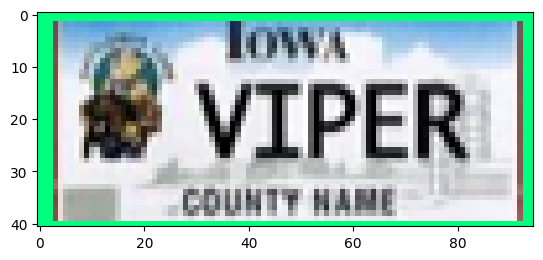

In [32]:
text,region= ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# Project Modification

In [ ]:
!pip install datetime

In [ ]:
!pip install ipython-sql

In [ ]:
!pip install mysqlclient

In [ ]:
!pip install pymysql

In [ ]:
!pip install mysql-connector

In [57]:
!pip install pyttsx3

  Using cached pyttsx3-2.90-py3-none-any.whl (39 kB)
  Using cached comtypes-1.1.14-py2.py3-none-any.whl (172 kB)
  Using cached pypiwin32-223-py3-none-any.whl (1.7 kB)


In [33]:
#user="root", password="", database="Rohan", host="localhost", port=3306
import pandas as pd
from sqlalchemy import create_engine
my_conn=create_engine("mysql+mysqldb://root:@localhost/Rohan")

In [34]:
df = pd.read_sql_query('Select * FROM anpr', my_conn)
df

,Licence,StateCode,State,Date,Day,Month,Time,Tag
0,AP63TY5129,AP,Andhra Pradesh,2023-04-22,Saturday,April,02:21:57,Visitor
1,MP75AV6469,MP,Madhya Pradesh,2023-05-21,Sunday,May,11:34:13,Visitor
2,AN27IL9412,AN,Andaman and Nicobar Islands,2023-06-03,Saturday,June,12:12:21,Visitor
3,LA24RB8017,LA,Ladakh,2023-05-14,Tuesday,May,22:28:27,Visitor
4,MZ98ZG8218,MZ,Mizoram,2023-06-24,Saturday,June,21:29:24,Visitor
5,LD43TD6919,LD,Lakshadweep,2023-06-28,Wednesday,June,05:35:20,Visitor
6,UP42BT2349,UP,Uttar Pradesh,2023-04-02,Sunday,April,19:38:37,Visitor
7,OD90XP7724,OD,Odisha,2023-04-06,Thursday,April,15:53:08,Visitor
8,KL37JG3407,KL,Kerala,2023-05-08,Monday,May,05:54:52,Visitor
9,MP30HH6850,MP,Madhya Pradesh,2023-05-04,Thursday,May,18:46:40,Visitor


In [35]:
from datetime import date
from datetime import datetime
import calendar
import datetime
import winsound
import pyttsx3

In [36]:
def get_state_name(code):
    state_dict = {
        "AN":"Andaman and Nicobar Islands",
      "AP": "Andhra Pradesh",
      "AR": "Arunachal Pradesh",
      "AS": "Assam",
      "BR": "Bihar",
      "CG": "Chhattisgarh",
      "DN": "Dadra and Nagar Haveli",
      "DD": "Daman and Diu",
      "DL": "Delhi",
      "GA": "Goa",
      "GJ": "Gujarat",
      "HR": "Haryana",
      "HP": "Himachal Pradesh",
      "JK": "Jammu and Kashmir",
      "JH": "Jharkhand",
      "KA": "Karnataka",
      "KL": "Kerala",
      "LA": "Ladakh",
      "LD": "Lakshadweep",
      "MP": "Madhya Pradesh",
      "MH": "Maharashtra",
      "MN": "Manipur",
      "ML": "Meghalaya",
      "MZ": "Mizoram",
      "NL": "Nagaland",
      "OD": "Odisha",
      "PB": "Punjab",
      "PY":"Pondicherry",
      "RJ": "Rajasthan",
      "SK": "Sikkim",
      "TN": "Tamil Nadu",
      "TS": "Telangana",
      "TR": "Tripura",
      "UP": "Uttar Pradesh",
      "UK": "Uttarakhand",
      "WB": "West Bengal"
    }
    return state_dict.get(code.upper(), "Invalid state code")

In [37]:
def check(s_indx, e_indx, plate):
    code=plate[s_indx:e_indx]
    if code.isalpha():
        print("OK:",code)
        return code
    else:
        s_indx+=1
        e_indx+=1
        return check(s_indx,e_indx,plate)

In [38]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threshold
    scores=list(filter(lambda x: x>detection_threshold, detections['detection_scores']))
    boxes=detections['detection_boxes'][:len(scores)]
    classes=detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width=image.shape[1]
    height=image.shape[0]
    
    #Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi=box*[height, width, height, width]
        region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader=easyocr.Reader(['en'])
        ocr_result=reader.readtext(region)
        
        text=filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        print(text)
        print(len(text))
        if len(text)==0:
            engine = pyttsx3.init()
            rate = engine.getProperty('rate')   # getting details of current speaking rate
            #print (rate)                        #printing current voice rate
            engine.setProperty('rate', 175)
            voices = engine.getProperty('voices')
            engine.setProperty('voice', voices[1].id)
            engine.say("License plate detection failed. Please follow the instructions of the staff member.")
            engine.runAndWait()
            #print("License plate detection failed. Please follow the instructions of the staff member.")
        else:
            engine = pyttsx3.init()
            rate = engine.getProperty('rate')   # getting details of current speaking rate
            #print (rate)                        #printing current voice rate
            engine.setProperty('rate', 175)
            voices = engine.getProperty('voices')
            engine.setProperty('voice', voices[1].id)
            engine.say("License plate detected. You may proceed.")
            engine.runAndWait()
            return text, region


In [39]:
def num_dec(image_name, detection_thres, region_thres):
    IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'detection_img', image_name)
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try:
        text, region=ocr_it(image_np_with_detections, detections, detection_thres, region_thres)
        l=text
        s_plate=l[0]
        numb_plate=s_plate.replace(' ','')
        print(numb_plate)
        
        #df = pd.read_sql_query('Select * FROM demo', my_conn)
        p_data=[]
        for i in df['Licence']:
            p_data.append(i)
        
        print(p_data)
        
        if numb_plate in p_data:
            tag='Resident'
        else:
            tag='Visitor'
            
        print("Tag:",tag)
        
        start_indx=0
        end_indx=2
        c=check(start_indx,end_indx, numb_plate)
        cd=c.upper()
        print("state code:",cd)
        
        state=get_state_name(cd)
        print("State:",state)
        
        #Date,Day,Month and Time
        today = date.today()
        print("Date:", today)
        now = datetime.datetime.now()
        
        #now = datetime.now()
        t=now.strftime("%H:%M:%S")
        print("Time:",t)
                
        #now = datetime.datetime.now()
        # Get weekday as an integer (Monday is 0 and Sunday is 6)
        weekday = now.weekday()
        weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        w=weekday_names[weekday]
        print('Day:',w)
        
        month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        m=month_names[now.month - 1]
        print("Month:",m)
        
        #Inserting to Database
        df1=pd.DataFrame([{"Licence":numb_plate, "StateCode":cd, "State":state, "Date":today, "Day":w, "Month":m, "Time":t, "Tag":tag}])
        df1.to_sql("anpr",my_conn, if_exists="append", index=False)
    except:
        pass
    
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()
    

screenshot taken


[]
0


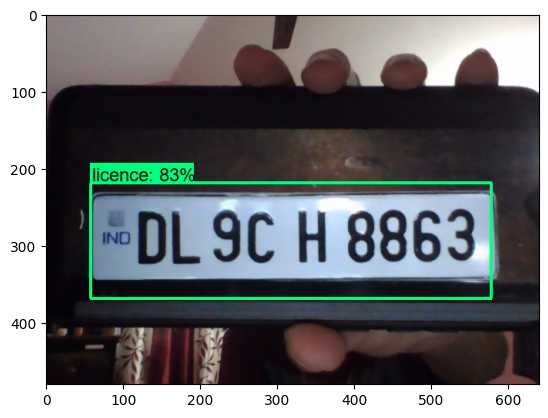

screenshot taken
['DL 9C H 8863']
1
DL9CH8863
['AP63TY5129', 'MP75AV6469', 'AN27IL9412', 'LA24RB8017', 'MZ98ZG8218', 'LD43TD6919', 'UP42BT2349', 'OD90XP7724', 'KL37JG3407', 'MP30HH6850', 'NL59VA1003', 'WB52II4713', 'GA13HD7562', 'UP23CT9016', 'GJ87AY7305', 'HP93TQ3108', 'UP32YT5286', 'DL17ZH3126', 'NL96YQ8870', 'JK58GA6967', 'UP51YH9033', 'MP68FU3316', 'ML49RU3745', 'HP16SG8100', 'KA38NO7085', 'KA19P84887', 'DL9CH8863', 'KA19P84887', 'KA19P8488', 'DL9CH8863', "KA19P8488'"]
Tag: Resident
OK: DL
state code: DL
State: Delhi
Date: 2023-08-25
Time: 07:38:05
Day: Friday
Month: August


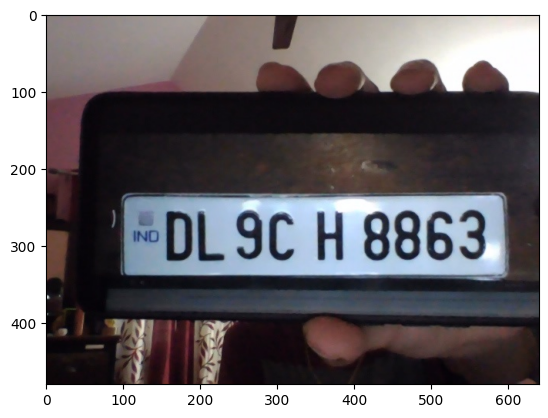

escape hit, closing the app


In [40]:
# importing the python open cv library
import cv2

# intialize the webcam and pass a constant which is 0
cam = cv2.VideoCapture(0)

# title of the app
#cv2.namedWindow('python webcam screenshot app')

# let's assume the number of images gotten is 0
img_counter = 0

# while loop
while True:
    # intializing the frame, ret
    ret, frame = cam.read()
    # if statement
    if not ret:
        print('failed to grab frame')
        break
    # the frame will show with the title of test
    cv2.imshow('test', frame)
    #to get continuous live video feed from my laptops webcam
    k  = cv2.waitKey(1)
    # if the escape key is been pressed, the app will stop
    if k%256 == 27:
        print('escape hit, closing the app')
        break
    # if the spacebar key is been pressed
    # screenshots will be taken
    elif k%256  == 32:
        
        # the format for storing the images scrreenshotted
        img_name = "opencv_frame_{}.jpg".format(img_counter)
        # saves the image as a png file
        cv2.imwrite(os.path.join(paths['IMAGE_PATH'], 'detection_img', img_name), frame)
        #os.path.join(paths['IMAGE_PATH'], 'detection_img', img_name)
        #cv2.imwrite(img_name, frame)
        print('screenshot taken')
        
        region_threshold=0.6
        detection_threshold=0.7
        
        num_dec(img_name, detection_threshold, region_threshold)
        # the number of images automaticallly increases by 1
        img_counter += 1

# release the camera
cam.release()

# stops the camera window
cv2.destroyAllWindows()


In [42]:
pd.read_sql("anpr",my_conn)

,Licence,StateCode,State,Date,Day,Month,Time,Tag
0,TN78ZP7868,TN,Tamil Nadu,2023-05-23,Tuesday,May,08:54:58,Visitor
1,AP63TY5129,AP,Andhra Pradesh,2023-04-22,Saturday,April,02:21:57,Visitor
2,MP75AV6469,MP,Madhya Pradesh,2023-05-21,Sunday,May,11:34:13,Visitor
3,AN27IL9412,AN,Andaman and Nicobar Islands,2023-06-03,Saturday,June,12:12:21,Visitor
4,LA24RB8017,LA,Ladakh,2023-05-13,Saturday,May,22:28:27,Visitor
5,MZ98ZG8218,MZ,Mizoram,2023-06-24,Saturday,June,21:29:24,Visitor
6,LD43TD6919,LD,Lakshadweep,2023-06-28,Wednesday,June,05:35:20,Visitor
7,UP42BT2349,UP,Uttar Pradesh,2023-04-02,Sunday,April,19:38:37,Visitor
8,OD90XP7724,OD,Odisha,2023-04-06,Thursday,April,15:53:08,Visitor
9,KL37JG3407,KL,Kerala,2023-05-08,Monday,May,05:54:52,Visitor


# 10. Real Time Detections from your Webcam

In [1]:
!pip uninstall opencv-python-headless -y

Found existing installation: opencv-python-headless 4.5.4.60
Uninstalling opencv-python-headless-4.5.4.60:
  Successfully uninstalled opencv-python-headless-4.5.4.60


In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')